In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask, CapsCNN
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.cifar import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (32, 32, 3)
m_train = 50000
m_test = 10000

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

# Model

In [18]:
model = Sequential([    
    Convolution2D(filters=128, kernel_size=(9, 9), padding='valid', activation='relu', input_shape=input_shape),
    Convolution2D(filters=128, kernel_size=(9, 9), strides=2, padding='valid', activation='relu'),
    
    CapsCNN(32, kernel_size=(5, 5), routings=3, activation_caps=squash),

    GlobalAveragePooling2D(),
    Dense(10, name='capsule')
])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 24, 24, 128)       31232     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         1327232   
_________________________________________________________________
caps_cnn_6 (CapsCNN)         (None, 4, 4, 32)          102400    
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
capsule (Dense)              (None, 10)                330       
Total params: 1,461,194
Trainable params: 1,461,194
Non-trainable params: 0
_________________________________________________________________


# Training

In [20]:
model.compile(optimizer=Adam(lr=3e-4),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [21]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=5,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Epoch 1/5
3125/3125 [==============================] - 80s 26ms/step - loss: 0.4230 - categorical_accuracy: 0.3461 - val_loss: 0.3839 - val_categorical_accuracy: 0.4196
Epoch 2/5
3125/3125 [==============================] - 78s 25ms/step - loss: 0.3658 - categorical_accuracy: 0.4510 - val_loss: 0.3460 - val_categorical_accuracy: 0.4774
Epoch 3/5
3125/3125 [==============================] - 78s 25ms/step - loss: 0.3415 - categorical_accuracy: 0.4941 - val_loss: 0.3336 - val_categorical_accuracy: 0.5067
Epoch 4/5
3125/3125 [==============================] - 79s 25ms/step - loss: 0.3239 - categorical_accuracy: 0.5232 - val_loss: 0.3202 - val_categorical_accuracy: 0.5290
Epoch 5/5
3125/3125 [==============================] - 78s 25ms/step - loss: 0.3101 - categorical_accuracy: 0.5466 - val_loss: 0.3078 - val_categorical_accuracy: 0.5494


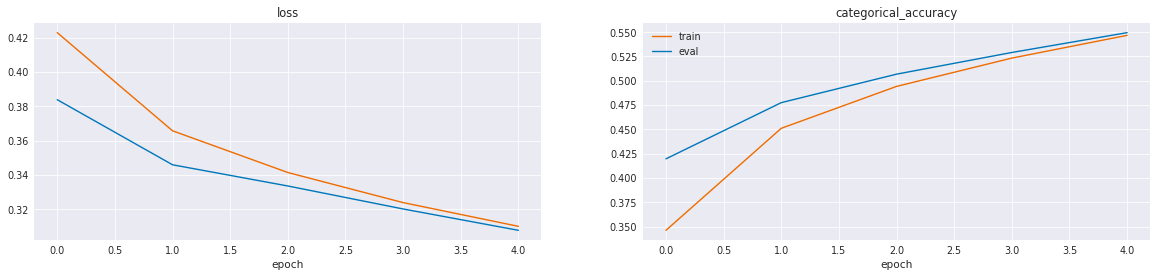

In [22]:
plotHistory(hist.history)
plt.savefig('cifar_history.png')